In [1]:
import json
import pandas as pd
import string
import time
import csv
import numpy as np
from tqdm import tqdm
import copy
import multiprocessing
import nltk
import re
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('jan_july_100_artile.csv')

In [9]:
df.head(10)

,Unnamed: 0,title,body,keywords,words_count
0,0,British Prime Minister Boris Johnson Hospitali...,"On Sunday, British Prime Minister Boris Johnso...","['Johnson', 'Hospitalized', 'Boris', 'Minister...",218
1,1,NSW coronavirus death toll hits 18 as cases ri...,NSW has now recorded 18 COVID-19 deaths as the...,"['cases', 'toll', 'death', 'coronavirus', 'COV...",278
2,2,Industry in Chandigarh will need major impetus...,ChandigarhWith shops and manufacturing units c...,"['government', 'impetus', 'major', 'post', 'Ch...",570
3,3,"Coronavirus in Chandigarh: Follow advisories, ...","Chandigarh The 23-year-old man, discharged fro...","['careful', 'advisories', '23-year-old', 'Chan...",348
4,4,Crackers sound jarring note as Chandigarh tric...,CHANDIGARH The stillness which had become so m...,"['Chandigarh', 'tricity', 'lights', 'note', 'j...",377
5,5,48% Covid-19 positive patients in Chandigarh t...,Chandigarh Health authorities have confirmed t...,"['Chandigarh', 'patients', 'tricity', 'positiv...",298
6,6,Covid 19 coronavirus: Huge price hikes for ess...,A freezer that cost $949 on March 1 shot up to...,"['hikes', 'price', 'essential', 'Huge', 'coron...",584
7,7,"Holy Week rites worldwide disrupted, but not s...",Attendees sit by palm branches as Pope Francis...,"['worldwide', 'rites', 'Week', 'Holy', 'spirit...",1015
8,8,Crucifixion site on lockdown to block penitents,Local tourists pose by crosses before a re-ena...,"['penitents', 'site', 'Crucifixion', 'lockdown...",326
9,9,COVID-19 patients to waive confidentiality,COVID-19 patients to waive confidentiality\n\n...,"['patients', 'confidentiality', 'COVID-19', 'm...",530


In [4]:
corpus_text = '\n'.join(df['body'])
sentences = corpus_text.split('\n')
sentences = [line.lower().split(' ') for line in sentences]

In [5]:
df.dropna(axis = 0, how ='any',inplace=True) 
df.drop_duplicates(subset=['body'],keep='first',inplace=True)

In [6]:
def clean_text(text ): 
    delete_dict = {sp_character: ' ' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower().split(' ')

In [7]:
df['body']= df['body'].apply(clean_text)

In [8]:
sentences = df['body'].tolist()

In [9]:
print(len(sentences))
print(sentences[1])
print(sentences[200])

99437
['nsw', 'has', 'now', 'recorded', 'covid', 'deaths', 'the', 'state', 'total', 'number', 'cases', 'rises', 'nsw', 'health', 'said', 'monday', 'the', 'state', 'had', 'recorded', 'new', 'cases', 'drop', 'the', 'previous', 'day', 'which', 'was', 'partly', 'explained', 'fewer', 'tests', 'being', 'done', 'over', 'the', 'weekend', 'the', 'death', 'toll', 'rose', 'after', 'the', 'deaths', 'year', 'old', 'man', 'and', 'year', 'old', 'man', 'sunday', 'comes', 'after', 'nsw', 'police', 'commissioner', 'mick', 'fuller', 'sunday', 'announced', 'investigation', 'into', 'the', 'circumstances', 'surrounding', 'the', 'docking', 'and', 'disembarkation', 'passengers', 'from', 'the', 'ill', 'fated', 'ruby', 'princess', 'cruise', 'ship', 'the', 'investigation', 'led', 'the', 'nsw', 'police', 'homicide', 'squad', 'aims', 'identify', 'how', 'passengers', 'were', 'allowed', 'disembark', 'from', 'the', 'ship', 'sydney', 'which', 'linked', 'covid', 'cases', 'and', 'least', 'deaths', 'across', 'the', 'coun

In [2]:
import gensim

In [13]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        elif self.epoch % 100 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        
        
        self.epoch += 1
        self.loss_previous_step = loss

In [14]:
# hyper parameters of the word2vec model
num_features = 200 # dimensions of each word embedding
min_word_count = 2 # this is not advisable but since we need to extract
# feature vector for each word we need to do this
num_workers = multiprocessing.cpu_count() # number of threads running in parallel
context_size = 7 # context window length
downsampling = 1e-3 # downsampling for very frequent words
seed = 1 # seed for random number generator to make results reproducible

In [17]:
# init word2vec class
w2v_model = Word2Vec(vector_size = num_features,
                     window = 10,
                     min_count = 2,
                     workers = num_workers,
                     sg = 0,
                    )
# build vovab


w2v_model.build_vocab(sentences)

  


In [20]:
# train the w2v model
start = time.time()
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=101, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()


print("elapsedtime in seconds :"+ str(end - start))


Loss after epoch 0: 4559433.0
Loss after epoch 100: 180552.0
elapsedtime in seconds :1539.015480041504


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\NLP\\Frame_NLP\\W2VData\\word2vec.model.wv.vectors.npy'

In [21]:
# save the word2vec model
w2v_model.save('D:\\NLP\\Frame_NLP\\Data\\word2vec.model')

In [7]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec

In [23]:
reloaded_w2v_model = Word2Vec.load('D:\\NLP\\Frame_NLP\\Data\\word2vec.model')
words = list(reloaded_w2v_model.wv.index_to_key)
print('Vocab size: '+str(len(words)))
w1 = 'vaccine'
print("Top 3 words similar to pandemic:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn =10))
w1 = 'vaccine'
print("Top 3 words similar to vaccine:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn =3))
print("Similarity between covid and virus:"+\
      str(reloaded_w2v_model.wv.similarity(w1="covid",w2="virus")))
print("Similarity between socialdistance and lockdown:"+\
      str(reloaded_w2v_model.wv.similarity(w1="socialdistance",w2="lockdown")))

Vocab size: 158997
Top 3 words similar to pandemic: [('vaccines', 0.8467559814453125), ('treatments', 0.647587239742279), ('cure', 0.5781174302101135), ('remdesivir', 0.5651286840438843), ('trials', 0.5456909537315369), ('vaccination', 0.5382245779037476), ('drugs', 0.5374522805213928), ('drug', 0.5349460244178772), ('antiviral', 0.5318850874900818), ('therapies', 0.5300467610359192)]
Top 3 words similar to vaccine: [('vaccines', 0.8467559814453125), ('treatments', 0.647587239742279), ('cure', 0.5781174302101135)]
Similarity between covid and virus:0.6743506
Similarity between socialdistance and lockdown:0.09896347


In [21]:
words = list(reloaded_w2v_model.wv.index_to_key)
print('Vocab size: '+str(len(words)))
w1 = 'case'
print("Top 3 words similar to pandemic:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn = 30))
w1 = 'epidemic'
print("Top 3 words similar to vaccine:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn = 10))
print("Similarity between covid and virus:"+\
      str(reloaded_w2v_model.wv.similarity(w1="covid",w2="virus")))
print("Similarity between socialdistance and lockdown:"+\
      str(reloaded_w2v_model.wv.similarity(w1="socialdistance",w2="lockdown")))

Vocab size: 158997
Top 3 words similar to pandemic: [('cases', 0.5730964541435242), ('patient', 0.5552523732185364), ('fatality', 0.49511784315109253), ('infection', 0.41934072971343994), ('suspect', 0.41496190428733826), ('infections', 0.4120182394981384), ('death', 0.3853720724582672), ('test', 0.3796953558921814), ('swph', 0.37094423174858093), ('resident', 0.36973366141319275), ('ca\xadse', 0.3694051206111908), ('casualty', 0.3658447563648224), ('diagnosis', 0.3646167814731598), ('suspected', 0.36166322231292725), ('incident', 0.36036238074302673), ('diagnoses', 0.35418954491615295), ('patients', 0.35163646936416626), ('outcome', 0.34564393758773804), ('offender', 0.3437351882457733), ('tricity’s', 0.3394487500190735), ('symptoms', 0.33709239959716797), ('victim', 0.3357071280479431), ('detected', 0.33392277359962463), ('person', 0.33344677090644836), ('incidence', 0.33258017897605896), ('r2tmc', 0.3320521414279938), ('symptom', 0.33146432042121887), ('chullickal', 0.32818353176116

In [15]:
words = list(reloaded_w2v_model.wv.index_to_key)
print('Vocab size: '+str(len(words)))
w1 = 'outbreak'
print("Top 5 words similar to w1",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn = 10))
w1 = 'coronavirus'
print("Top 5 words similar to w1:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn = 10))
w1 = 'outbreak'
print("Top 5 words similar to w1:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn = 10))
w1 = 'quarantine'
print("Top 5 words similar to w1",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn = 10))
w1 = 'pandemic'
print("Top 5 words similar to w1",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn = 10))

Vocab size: 158997
Top 5 words similar to w1 [('pandemic', 0.9028194546699524), ('epidemic', 0.7563018798828125), ('crisis', 0.7130113840103149), ('shutdown', 0.5839642882347107), ('spread', 0.5731232166290283), ('novel', 0.5596203207969666), ('lockdowns', 0.5321853756904602), ('shutdowns', 0.521510124206543), ('outbreaks', 0.5190264582633972), ('lockdown', 0.5128319263458252)]
Top 5 words similar to w1: [('covid', 0.9111222624778748), ('virus', 0.6774252653121948), ('virus’s', 0.4691252112388611), ('virus’', 0.45946434140205383), ('covid19', 0.4545608460903168), ('nationwide', 0.44572553038597107), ('worldwide', 0.40469226241111755), ('coronavirus’', 0.39840149879455566), ('“coronavirus', 0.38066521286964417), ('worsening', 0.37945571541786194)]
Top 5 words similar to w1: [('pandemic', 0.9028194546699524), ('epidemic', 0.7563018798828125), ('crisis', 0.7130113840103149), ('shutdown', 0.5839642882347107), ('spread', 0.5731232166290283), ('novel', 0.5596203207969666), ('lockdowns', 0.53

In [26]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.index_to_key:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    #labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(reloaded_w2v_model)

c:\users\hp\miniconda3\envs\nlp_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\hp\miniconda3\envs\nlp_env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


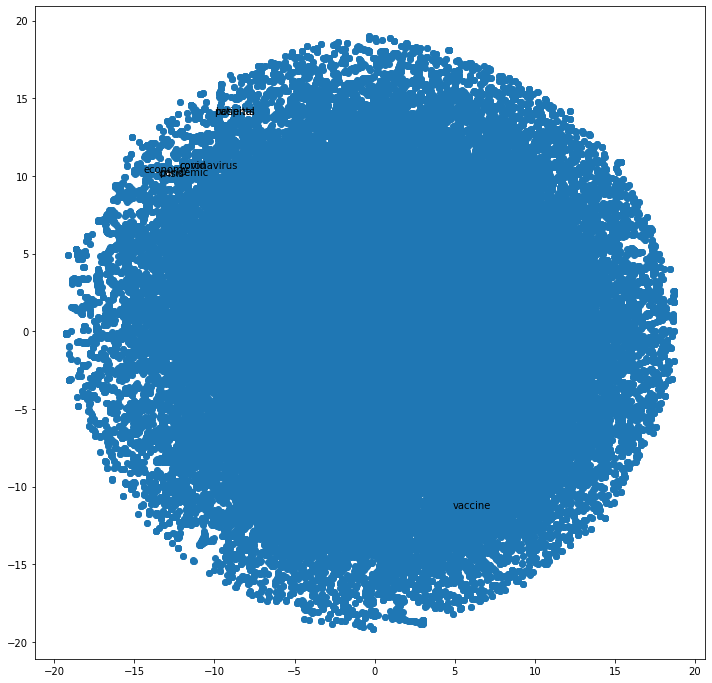

In [29]:
def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    
    
    indices = list(range(len(labels)))
    #selected_indices = random.sample(indices, 25)
    selected_indices=[]
    index = labels.index("coronavirus")
    selected_indices.append(index)
    index = labels.index("pandemic")
    selected_indices.append(index)
    index = labels.index("crisis")
    selected_indices.append(index)
    index = labels.index("economy")
    selected_indices.append(index)
    index = labels.index("covid")
    selected_indices.append(index)
    index = labels.index("hospital")
    selected_indices.append(index)
    index = labels.index("patients")
    selected_indices.append(index)
    index = labels.index("vaccine")
    selected_indices.append(index)
    
    
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))



plot_function = plot_with_matplotlib


plot_function(x_vals, y_vals, labels)